In [91]:
import os
from shutil import copyfile, rmtree

import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

from torchvision.models import vgg16_bn

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow


import warnings; warnings.simplefilter('ignore')

import PIL
from PIL import ImageDraw

%matplotlib inline

In [92]:
data_dir = "./games_composite"

# Setup Data

## Collect the position csv for every game

In [106]:
# df = pd.read_csv("./fog_positions.csv")
# df['tags'].replace(' ', np.nan, inplace=True)
# df = df.dropna()
# df
df = pd.DataFrame(columns=["image_name", "tags"])
for g in os.listdir("./games"):
    try:
        game_df = pd.read_csv(f'./games/{g}/full/full_{g}.csv')
        df = df.append(game_df)
    except:
        pass
df

,image_name,tags
0,ahq_ig_1_worlds_oct_12_2019_0000000168,12;13;player 12;14;player 12;15;player 13;13;p...
1,ahq_ig_1_worlds_oct_12_2019_0000000973,10;7;player 10;8;player 11;10;player 11;11;pla...
2,ahq_ig_1_worlds_oct_12_2019_0000000268,10;24;player 10;25;player 10;26;player 11;3;pl...
3,ahq_ig_1_worlds_oct_12_2019_0000000169,12;14;player 12;15;player 13;13;player 13;14;p...
4,ahq_ig_1_worlds_oct_12_2019_0000000198,14;10;player 14;14;player 14;15;player 14;16;p...
...,...,...
1291,lec_2020_og_rge_0000000957,10;21;player 10;22;player 10;8;player 11;16;pl...
1292,lec_2020_og_rge_0000000694,0;8;player 10;10;player 10;11;player 10;8;play...
1293,lec_2020_og_rge_0000000442,10;3;player 10;4;player 10;5;player 10;6;playe...
1294,lec_2020_og_rge_0000000447,10;2;player 10;3;player 10;4;player 10;5;playe...


## Cleanup the dataframe

In [107]:
actual = os.listdir(f"{data_dir}/team")
actual = [a.replace(".png", "") for a in actual]
composites = {}
for a in actual:
    composites[a] = True

df = df.sort_values(by=['image_name'])
df = df[df['image_name'].isin(actual)]

# Train the Model

## Setup the Databatch

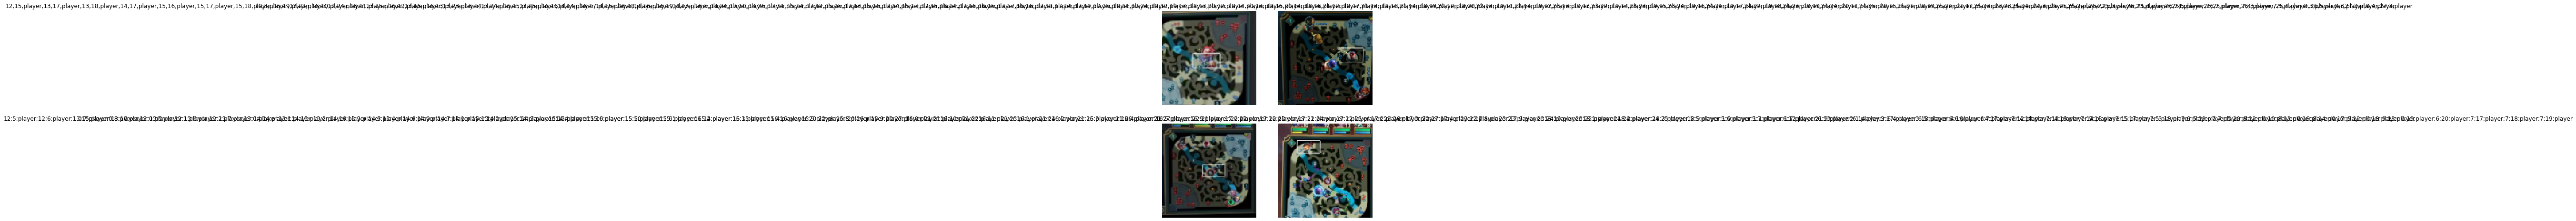

In [108]:
res = []
res.append(symmetric_warp(magnitude=(-0.05,0.05), p=0.75))
res.append(rotate(degrees=(-2.,2.), p=0.75))
res.append(rand_zoom(scale=(1.,1.3), p=0.75))
res.append(brightness(change=(0.5*(1-0.4), 0.5*(1+0.4)), p=0.75))
res.append(contrast(scale=(1-0.2, 1/(1-0.2)), p=0.75))

tfms = (res, [])

src = (ImageList.from_df(df, data_dir+"/team", suffix=".png", cols=0)
                .split_by_idx(range(0,len(df)//5))
                .label_from_df(label_delim=' ', cols=1))

data = ImageDataBunch.create_from_ll(src, ds_tfms=tfms, size=128)

data.show_batch(rows=2)

## Train

In [109]:
learn = None
gc.collect()

thresh = 0.2
acc_02 = partial(accuracy_thresh, thresh=thresh)
learn = create_cnn(data, models.resnet101, metrics=[acc_02])
learn.callbacks = [SaveModelCallback(learn, every='improvement', mode='min', name='best')]

In [110]:
# learn.lr_find()
# learn.recorder.plot()

In [111]:
lr = 0.01
learn.fit_one_cycle(1, lr)

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.190160,0.156150,0.916578,05:54


Better model found at epoch 0 with valid_loss value: 0.15615001320838928.


In [112]:
learn.unfreeze()

In [113]:
learn.fit_one_cycle(6, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,time


KeyboardInterrupt: 

### Results
* Resnet50 bs:96 (6, slice(1e-5, lr/5)) 0.1478717178106308

In [81]:
preds = learn.get_preds(ds_type=DatasetType.Valid)

In [82]:
grid_size = 5
def draw_grid(draw, labels):
    for l in labels:
        x = l[0]*grid_size
        y = l[1]*grid_size+10
        fill = (255, 0, 0, 96)
        draw.rectangle((x, y, x + grid_size, y + grid_size), fill=fill)
        
def process(image):
    plt.figure()
    plt.imshow(image)
        
def draw_preds(index):
    p = preds[0][index]
    classes = [data.classes[i] for i in range(len(p)) if p[i] > thresh]
    classes = [(int(c.split(";")[0]), int(c.split(";")[1])) for c in classes]

    filename = learn.data.valid_ds.items[index]
    
    img = PIL.Image.open(filename).convert("RGBA")
    overlay = PIL.Image.new('RGBA', img.size, (255, 255, 255, 0))
    draw = ImageDraw.Draw(overlay)
    draw_grid(draw, classes)
    out = PIL.Image.alpha_composite(img, overlay)

    process(out)
    full_name = filename.split("/")[-1]
    full_name = data_dir+"/full/"+full_name
    img = PIL.Image.open(full_name)
    process(img)

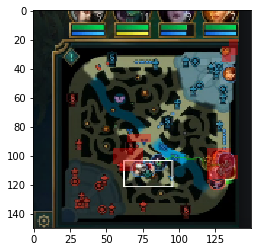

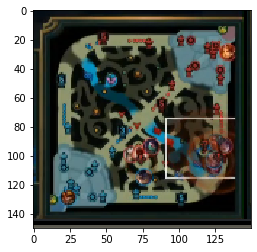

In [89]:
thresh = 0.2
k = random.randint(10, 8000)
draw_preds(k)

In [90]:
learn.export("models/predict.pth")
print(learn.data.path)

games_composite/team
